In [4]:
!curl --version

curl 8.16.0 (Windows) libcurl/8.16.0 Schannel zlib/1.3.1 WinIDN
Release-Date: 2025-09-10
Protocols: dict file ftp ftps gopher gophers http https imap imaps ipfs ipns ldap ldaps mqtt pop3 pop3s smb smbs smtp smtps telnet tftp ws wss
Features: alt-svc AsynchDNS HSTS HTTPS-proxy IDN IPv6 Kerberos Largefile libz NTLM SPNEGO SSL SSPI threadsafe Unicode UnixSockets


In [5]:
!curl -L -o images.npz https://github.com/DivyanshuTak/Ultrasoud_Unet_Segmentation/raw/refs/heads/main/images.npz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

  7 9601k    7  686k    0     0   439k      0  0:00:21  0:00:01  0:00:20  439k
 24 9601k   24 2338k    0     0   912k      0  0:00:10  0:00:02  0:00:08 1651k
 49 9601k   49 4773k    0     0  1339k      0  0:00:07  0:00:03  0:00:04 2042k
 87 9601k   87 8444k    0     0  1851k      0  0:00:05  0:00:04  0:00:01 2585k
100 9601k  100 9601k    0     0  1875k      0  0:00:05  0:00:05 --:--:-- 2506k


In [6]:
%pylab inline 

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [7]:
%matplotlib inline

In [8]:
data = np.load("images.npz")

In [9]:
data

NpzFile 'images.npz' with keys: images, filenames

In [10]:
all_images = data['images']

In [11]:
all_images.shape

(208, 300, 300, 3)

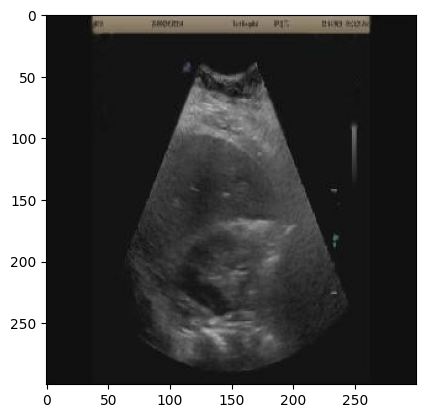

In [12]:
imshow(all_images[0])

In [13]:
!curl -L -o masks.npz https://github.com/DivyanshuTak/Ultrasoud_Unet_Segmentation/raw/refs/heads/main/masks.npz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

100 92714  100 92714    0     0   220k      0 --:--:-- --:--:-- --:--:--  220k


In [14]:
data2 = np.load("masks.npz")

In [15]:
data2

NpzFile 'masks.npz' with keys: masks, filenames

In [16]:
allmasks = data2["masks"]

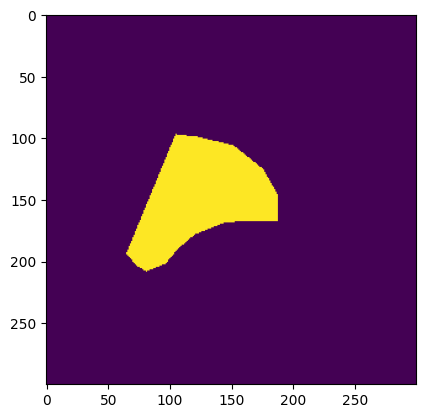

In [17]:
imshow(allmasks[0])

In [18]:
allmasks.shape

(208, 300, 300)

In [19]:
allmasks.dtype

dtype('uint8')

In [20]:
def show_overlay(index):
    plt.imshow(all_images[index], cmap='gray')
    plt.imshow(allmasks[index], cmap='jet', alpha=0.4)
    plt.axis('off')
    plt.show()

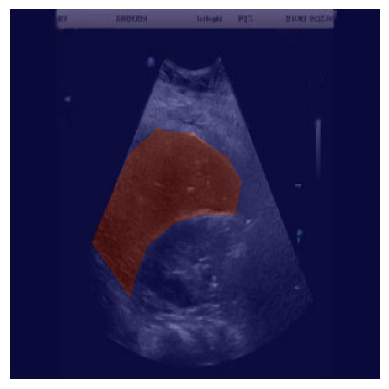

In [21]:
show_overlay(10)

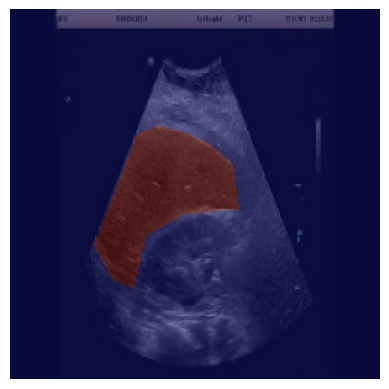

In [22]:
show_overlay(99)

In [23]:
def show_10_overlays():
    plt.figure(figsize=(15, 6))
    
    for i in range(10):
        plt.subplot(2, 5, i+1)
        plt.imshow(all_images[i], cmap='gray')
        plt.imshow(allmasks[i], cmap='jet', alpha=0.4)
        plt.axis('off')
    
    plt.show()

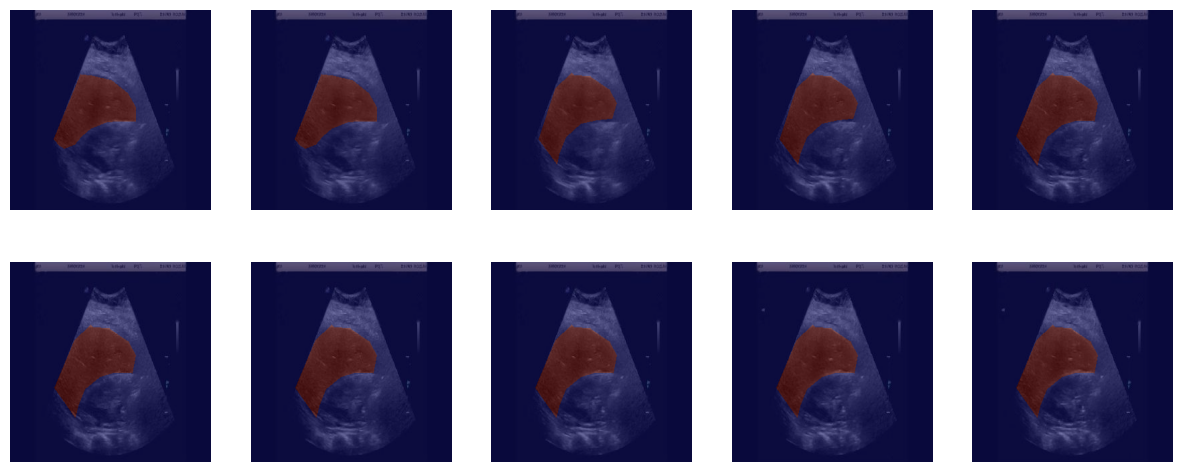

In [24]:
show_10_overlays()

In [25]:
print("hi")

hi


In [30]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Model

In [31]:
import numpy as np

X = all_images.astype("float32")
Y = allmasks.astype("float32")

# remove extra last dim if it exists (your case: ... ,1)
if X.ndim == 5: X = X.squeeze(-1)
if Y.ndim == 5: Y = Y.squeeze(-1)

# add channel ONLY if grayscale (N,H,W)
if X.ndim == 3: X = X[..., None]
if Y.ndim == 3: Y = Y[..., None]

# normalize + binarize
if X.max() > 1.0: X = X / 255.0
Y = (Y > 0).astype("float32")

print("X:", X.shape, "Y:", Y.shape)

X: (208, 300, 300, 3) Y: (208, 300, 300, 1)


In [32]:
# Shuffle
idx = np.random.permutation(len(X))
X, Y = X[idx], Y[idx]

# 80/20 split
split = int(0.8 * len(X))
X_train, X_val = X[:split], X[split:]
y_train, y_val = Y[:split], Y[split:]

print("Train:", X_train.shape, y_train.shape)
print("Val:", X_val.shape, y_val.shape)

Train: (166, 300, 300, 3) (166, 300, 300, 1)
Val: (42, 300, 300, 3) (42, 300, 300, 1)


In [33]:
import tensorflow as tf
from tensorflow.keras import layers, Model

def simple_unet(input_shape):
    inp = layers.Input(input_shape)

    # Down
    c1 = layers.Conv2D(16, 3, activation="relu", padding="same")(inp)
    c1 = layers.Conv2D(16, 3, activation="relu", padding="same")(c1)
    p1 = layers.MaxPool2D()(c1)

    c2 = layers.Conv2D(32, 3, activation="relu", padding="same")(p1)
    c2 = layers.Conv2D(32, 3, activation="relu", padding="same")(c2)
    p2 = layers.MaxPool2D()(c2)

    # Bottom
    b = layers.Conv2D(64, 3, activation="relu", padding="same")(p2)

    # Up
    u2 = layers.UpSampling2D()(b)
    u2 = layers.Concatenate()([u2, c2])
    c3 = layers.Conv2D(32, 3, activation="relu", padding="same")(u2)

    u1 = layers.UpSampling2D()(c3)
    u1 = layers.Concatenate()([u1, c1])
    c4 = layers.Conv2D(16, 3, activation="relu", padding="same")(u1)

    out = layers.Conv2D(1, 1, activation="sigmoid")(c4)
    return Model(inp, out)

model = simple_unet(X_train.shape[1:])
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 300, 300, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 300, 300, 16)      │             448 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 300, 300, 16)      │           2,320 │ conv2d_1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 150, 150, 16)      │               0 │ conv2d_2[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 150, 150, 32)      │           4,640 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_4 (Conv2D)             │ (None, 150, 150, 32)      │           9,248 │ conv2d_3[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_1               │ (None, 75, 75, 32)        │               0 │ conv2d_4[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_5 (Conv2D)             │ (None, 75, 75, 64)        │          18,496 │ max_pooling2d_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ up_sampling2d (UpSampling2D)  │ (None, 150, 150, 64)      │               0 │ conv2d_5[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 150, 150, 96)      │               0 │ up_sampling2d[0][0],       │
│                               │                           │                 │ conv2d_4[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_6 (Conv2D)             │ (None, 150, 150, 32)      │          27,680 │ concatenate[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ up_sampling2d_1               │ (None, 300, 300, 32)      │               0 │ conv2d_6[0][0]             │
│ (UpSampling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_1 (Concatenate)   │ (None, 300, 300, 48)      │               0 │ up_sampling2d_1[0][0],     │
│                               │                           │                 │ conv2d_2[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_7 (Conv2D)             │ (None, 300, 300, 16)      │           6,928 │ concatenate_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_8 (Conv2D)             │ (None, 300, 300, 1)       │              17 │ conv2d_7[0][0]             │
└───────────────────────────────┴───────────────────────────┴───────────────

 Total params: 69,777 (272.57 KB)

 Trainable params: 69,777 (272.57 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=5,
    batch_size=2
)

Epoch 1/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 33s 347ms/step - accuracy: 0.9095 - loss: 0.2685 - val_accuracy: 0.9194 - val_loss: 0.1593
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 37s 294ms/step - accuracy: 0.9186 - loss: 0.1688 - val_accuracy: 0.9194 - val_loss: 0.1543
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 46s 356ms/step - accuracy: 0.9186 - loss: 0.1526 - val_accuracy: 0.9194 - val_loss: 0.1479
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 36s 299ms/step - accuracy: 0.9186 - loss: 0.1603 - val_accuracy: 0.9194 - val_loss: 0.1489
Epoch 5/5
